<h1>Spis treści<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Dane" data-toc-modified-id="Dane-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dane</a></span></li><li><span><a href="#Model-v0" data-toc-modified-id="Model-v0-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model v0</a></span></li><li><span><a href="#Optymalizacja-parametrów" data-toc-modified-id="Optymalizacja-parametrów-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optymalizacja parametrów</a></span></li><li><span><a href="#Model-diagnostics" data-toc-modified-id="Model-diagnostics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model diagnostics</a></span></li><li><span><a href="#Feature-importances" data-toc-modified-id="Feature-importances-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature importances</a></span></li><li><span><a href="#Kalibracja-pierwotna" data-toc-modified-id="Kalibracja-pierwotna-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Kalibracja pierwotna</a></span></li><li><span><a href="#Kalibracja-docelowa" data-toc-modified-id="Kalibracja-docelowa-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Kalibracja docelowa</a></span></li><li><span><a href="#Mapowanie-ratingów" data-toc-modified-id="Mapowanie-ratingów-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Mapowanie ratingów</a></span></li><li><span><a href="#Rating-assigment" data-toc-modified-id="Rating-assigment-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Rating assigment</a></span></li><li><span><a href="#Strategy-curve" data-toc-modified-id="Strategy-curve-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Strategy curve</a></span></li><li><span><a href="#Użyj-modelu" data-toc-modified-id="Użyj-modelu-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Użyj modelu</a></span></li></ul></div>

##### Imports

Pakiet pod model:
pd_to_score(df, PD_start, offset_start=700, PDO=50 )
PD_calibration_from_score(df,ile_grup, pd_ref=0.01, score_offset_start=700,  PDO=50)
score_to_rating_bucketing(df, ile_ratingow)

Zastosowanie kalibracji:
score_to_rating_assign(df, score_buckets, stats=False)
score_to_PD_calibration(df, alpha, beta)


Ocena:
importances_calc(X_test, y_test, permutation_repeats=60)
make_confusion_matrix(y_test, y_test_pred, proba_cutoff, title=None)

Wykresy:
plot_classification_stats(y, y_pred)
plot_raw_calibration(y_test, test_proba,title)
plot_final_calibration(df,ile_kubelkow, bar_width=25)
plot_strategy_curve(df)
plot_strategy_curve_plotly(df)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

import utils_gb as ugb
from utils_gb import  utils_stats as ugbS
from utils_gb import  utils_plots as ugbP
import importlib

from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, partial

##### Dane

In [2]:
# Wykorzystywane od punktu 3.1 do zabawy binning i modelami
uci_credit_card= pd.read_csv('data/UCI_Credit_Card.csv')
uci_credit_card_target=uci_credit_card.columns[-1]
uci_credit_card_features=uci_credit_card.columns[1:6]  #[1:-1]
uci_credit_card_features=uci_credit_card.columns[1:-1]

X=uci_credit_card.loc[:,uci_credit_card_features]
y=uci_credit_card.loc[:,uci_credit_card_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2019)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2019)
 
print('TRAIN:',X_train.shape, y_train.shape)
print('TEST:',X_test.shape, y_test.shape)
print('VALIDATION:',X_val.shape, y_val.shape)

TRAIN: (18000, 23) (18000,)
TEST: (6000, 23) (6000,)
VALIDATION: (6000, 23) (6000,)


##### Model v0

In [3]:
xgbR=XGBClassifier(random_state=112
                  , max_depth=4
                  , min_child_weight=10
                  , n_estimators=50
                  , learning_rate=0.15
                  , eval_metric='auc'
                  , objective='binary:logistic'
                  ,booster= 'gbtree' # gbtree gblinear  dart.

                 )
xgbR.fit(X_train, y_train)

xgbR_y_train_pred = xgbR.predict_proba(X_train)[:, 1]
xgbR_y_test_pred = xgbR.predict_proba(X_test)[:, 1]
auc_train= round(roc_auc_score(y_train, xgbR_y_train_pred),4) 
auc_test= round(roc_auc_score(y_test, xgbR_y_test_pred),4) 

#display({'auc_train': auc_train, 'auc_test': auc_test})
#display({'gini_train': round(auc_train*2-1,4), 'gini_test': round(auc_test*2-1,4)})

measures = ugbS.calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val,xgbR)
measures

Proba cut-off: 0.5
Proba cut-off: 0.5
Proba cut-off: 0.5


AUC    GINI  Accuracy  Balanced Accuracy  F1 score  Recall  \
TRAIN  0.8114  0.6228    0.8252             0.6610    0.8949  0.9569   
TEST   0.7877  0.5754    0.8225             0.6566    0.8933  0.9546   
OOT    0.7910  0.5820    0.8293             0.6618    0.8978  0.9577   

       Precision     FPR     FOR  
TRAIN     0.8404  0.6350  0.2920  
TEST      0.8394  0.6414  0.3077  
OOT       0.8451  0.6341  0.2948

##### Optymalizacja parametrów

In [4]:
def objective(space):
    xgb_params = {
        # ogólne
        'learning_rate': space['learning_rate'],
        'max_depth': int(space['max_depth']),
        'n_estimators': int(space['n_estimators']),
        'min_child_weight': int(space['min_child_weight']),
        'gamma': space['gamma'],
        'seed': space['seed'], 
        # do walki z overfiting
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'colsample_bylevel': space['colsample_bylevel'],
        'max_delta_step': 0,
        # regularyzacja
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'scale_pos_weight':space['scale_pos_weight'],
        # pozostałe
        'metric': 'auc',  
        'eval_metric': 'auc', 
        'tree_method': 'gpu_hist',
        'objective':'binary:logistic',
        'booster': 'gbtree'
    }
 
    model = XGBClassifier(**xgb_params,verbosity = 0)
    model.fit(X_train, y_train)
    y_test_pred = model.predict_proba(X_test)[:, 1]
    y_train_pred = model.predict_proba(X_train)[:, 1]
    score = - roc_auc_score(y_test, y_test_pred) #to będę minimalizował
    score_test=-score
    score_train=roc_auc_score(y_train, y_train_pred)
    BS_results.append([score_test,score_train,2*score_test-1,2*score_train-1, xgb_params])
    #print("{0}. Score: test-> {1:.4} , train-> {2:.4} ".format(len(BS_results),roc_auc_score(y_test, y_test_pred),roc_auc_score(y_train, y_train_pred)))
    print(f"{len(BS_results):5}. (train, test) GINI: ({2*score_train-1: 7.2%},{2*score_test-1: 7.2%}) ")
     
    return{'loss':score, 'status': STATUS_OK }

In [5]:
params_range_0 ={ #wlasne
    'learning_rate': hp.uniform ('learning_rate', 0.01, 0.5),
    'max_depth': hp.quniform ('max_depth', 4, 10, 1),
    'n_estimators': hp.quniform ('n_estimators', 50, 400, 50),
    'min_child_weight': hp.quniform ('min_child_weight', 5, 100, 5),
    'gamma': hp.loguniform ('gamma', 1.0, 9.0),
    'seed':112,
    'subsample': hp.uniform ('subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.0),
    'reg_alpha': hp.loguniform ('reg_alpha', 0.0, 9.0),
    'reg_lambda': hp.loguniform ('reg_lambda', 0.0, 9.0),
    'scale_pos_weight': hp.quniform ('scale_pos_weight', 1.0, 11.0, 1)
}

    1. (train, test) GINI: (  0.00%,  0.00%)                                                                           
    2. (train, test) GINI: ( 56.30%, 57.21%)                                                                           
    3. (train, test) GINI: ( 73.93%, 56.27%)                                                                           
    4. (train, test) GINI: (  0.00%,  0.00%)                                                                           
    5. (train, test) GINI: ( 53.08%, 55.10%)                                                                           
    6. (train, test) GINI: ( 43.49%, 47.50%)                                                                           
    7. (train, test) GINI: ( 54.58%, 56.41%)                                                                           
    8. (train, test) GINI: ( 42.62%, 46.76%)                                                                           
    9. (train, test) GINI: ( 45.16%, 49.

   69. (train, test) GINI: ( 55.79%, 57.15%)                                                                           
   70. (train, test) GINI: ( 56.09%, 57.48%)                                                                           
   71. (train, test) GINI: ( 55.19%, 57.24%)                                                                           
   72. (train, test) GINI: ( 59.08%, 57.64%)                                                                           
   73. (train, test) GINI: ( 56.91%, 57.84%)                                                                           
   74. (train, test) GINI: ( 53.39%, 55.38%)                                                                           
   75. (train, test) GINI: ( 53.50%, 55.33%)                                                                           
   76. (train, test) GINI: ( 58.78%, 57.99%)                                                                           
   77. (train, test) GINI: ( 59.52%, 57.

0.5825715251726749

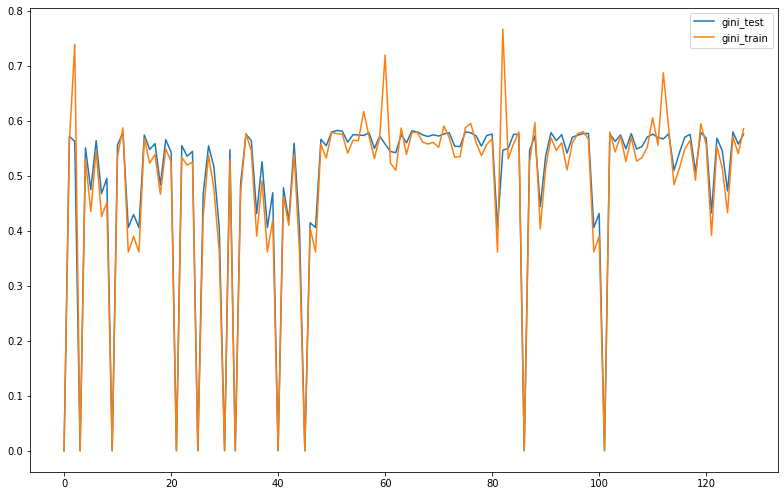

In [42]:
# parametr mówiący ile iteracji najpierw losujemy zanim zaczniemy optymalizować parametry
n_startup_jobs = 48 # liczba całkowita > 0
 
# parametr ile łącznie robimy iteracji 
max_evals = 4*4*4*2 # liczba całkowita > n_startup_jobs
 
BS_results = []

trials = Trials()
best_params = fmin(fn=objective,
                   space=params_range_0,
                   algo=partial(tpe.suggest, n_startup_jobs=n_startup_jobs),
                   max_evals=max_evals,
                   trials=trials)
 
print("The best params: ", best_params)
BS_results=pd.DataFrame(BS_results,columns=['auc_test','auc_train','gini_test','gini_train','param'])
BS_results.loc[:,['gini_test','gini_train']].plot()
BS_results.gini_test.max()

In [43]:
params_final={'colsample_bylevel': best_params['colsample_bylevel'],
 'colsample_bytree': best_params['colsample_bytree'],
 'gamma': best_params['gamma'],
 'learning_rate': best_params['learning_rate'],
 'max_depth': best_params['max_depth'].astype(int),
 'min_child_weight':  best_params['min_child_weight'].astype(int),
 'n_estimators':  best_params['n_estimators'].astype(int),
 'reg_alpha': best_params['reg_alpha'],
 'reg_lambda': best_params['reg_lambda'],
 'scale_pos_weight': best_params['scale_pos_weight'],
 'subsample':best_params['subsample'],
 'seed':112,
 'metric': 'auc',  
 'eval_metric': 'auc', 
 'tree_method': 'gpu_hist',
 'objective':'binary:logistic',
 'booster': 'gbtree'
  }
display(BS_results.iloc[:,0:5].sort_values(by=['gini_test']).tail(1))
display(params_final)

auc_test  auc_train  gini_test  gini_train  \
51  0.791286   0.788346   0.582572    0.576693   

                                                param  
51  {'learning_rate': 0.4184294663128552, 'max_dep...

{'colsample_bylevel': 0.6606374550686717,
 'colsample_bytree': 0.8060024308676443,
 'gamma': 4.734311203631119,
 'learning_rate': 0.4184294663128552,
 'max_depth': 7,
 'min_child_weight': 65,
 'n_estimators': 50,
 'reg_alpha': 13.429713140344104,
 'reg_lambda': 2573.365247923513,
 'scale_pos_weight': 7.0,
 'subsample': 0.9416533453181224,
 'seed': 112,
 'metric': 'auc',
 'eval_metric': 'auc',
 'tree_method': 'gpu_hist',
 'objective': 'binary:logistic',
 'booster': 'gbtree'}

In [44]:
xgbBest = XGBClassifier(**params_final)
xgbBest.fit(X_train, y_train,early_stopping_rounds=500, eval_set=[(X_train,y_train),(X_test,y_test)],verbose=50)  
measures = ugbS.calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val,xgbBest)
y_train_pred = xgbBest.predict_proba(X_train)[:, 1]
y_test_pred = xgbBest.predict_proba(X_test)[:, 1]
y_val_pred = xgbBest.predict_proba(X_val)[:, 1]
measures

[0]	validation_0-auc:0.70591	validation_1-auc:0.70422


d:\02_venv\gb1\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[49]	validation_0-auc:0.78835	validation_1-auc:0.79129
Proba cut-off: 0.5
Proba cut-off: 0.5
Proba cut-off: 0.5


AUC    GINI  Accuracy  Balanced Accuracy  F1 score  Recall  \
TRAIN  0.7883  0.5767    0.5670             0.6725    0.6340  0.4824   
TEST   0.7913  0.5826    0.5653             0.6683    0.6338  0.4833   
OOT    0.7897  0.5795    0.5718             0.6725    0.6441  0.4948   

       Precision     FPR     FOR  
TRAIN     0.9247  0.1373  0.6771  
TEST      0.9205  0.1466  0.6801  
OOT       0.9226  0.1499  0.6822

##### Model diagnostics

'proba cut-off (confusion matrix):76.44%'

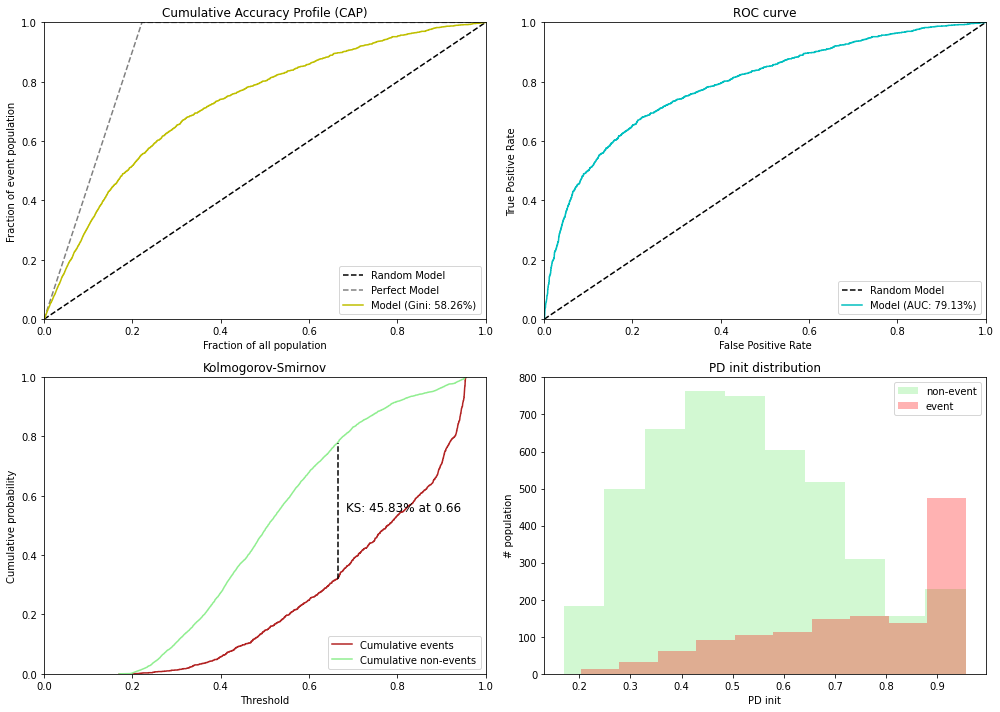

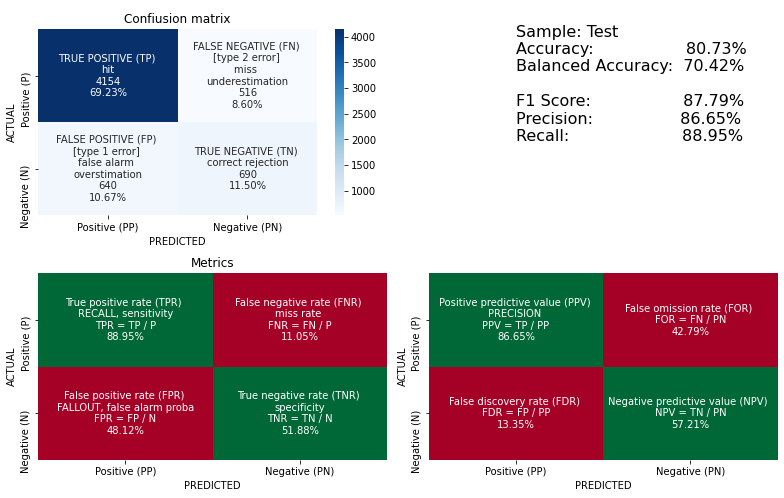

In [45]:
gini, auc, ks, ks_at=ugbP.plot_classification_stats(y_test, y_test_pred)
ugbS.make_confusion_matrix(y_test, y_test_pred, proba_cutoff=min(ks_at*1.15,0.9), title='Test')

##### Feature importances

d:\02_venv\gb1\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



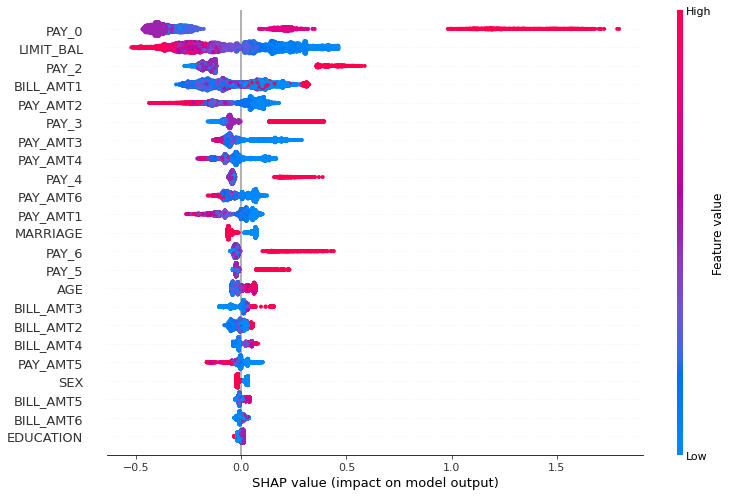

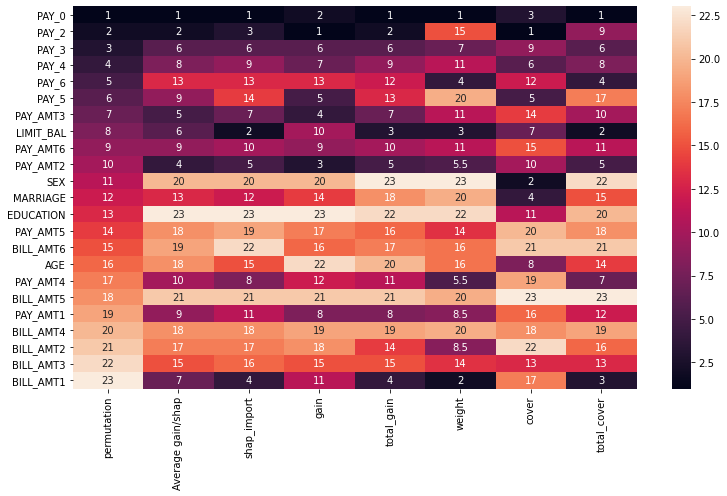

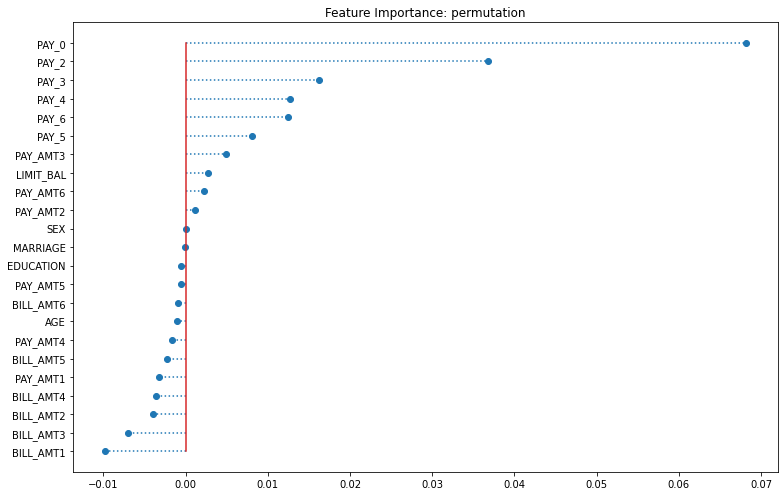

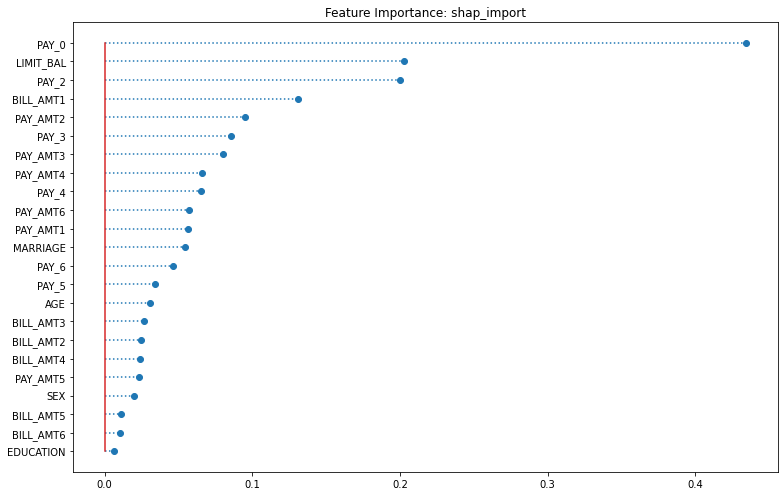

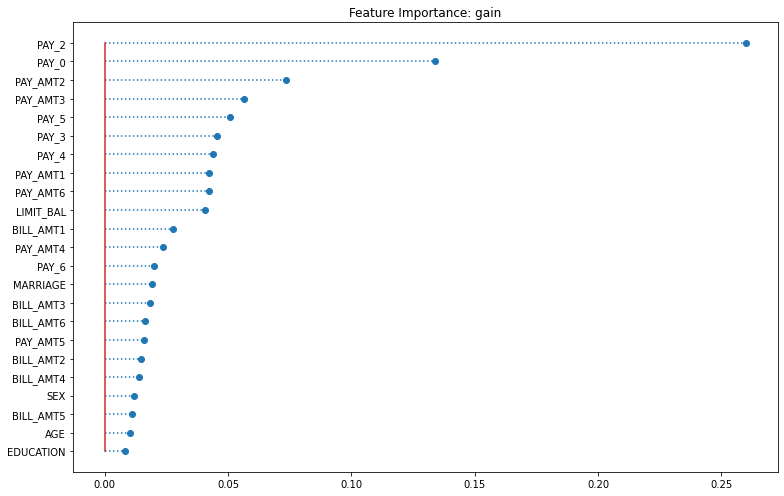

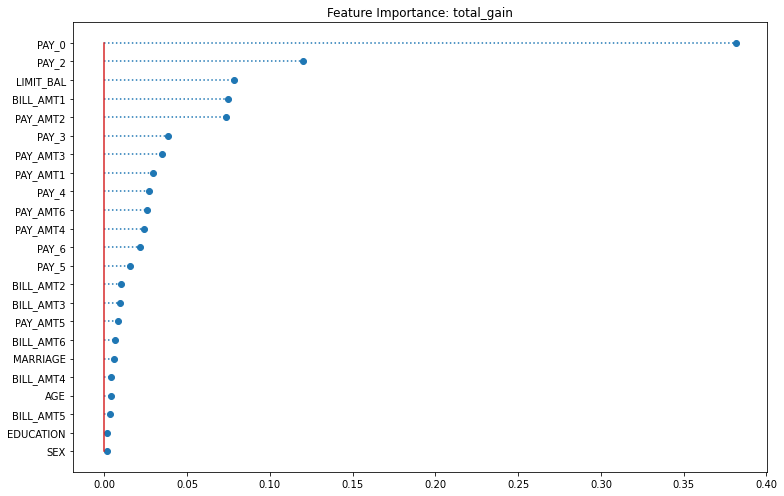

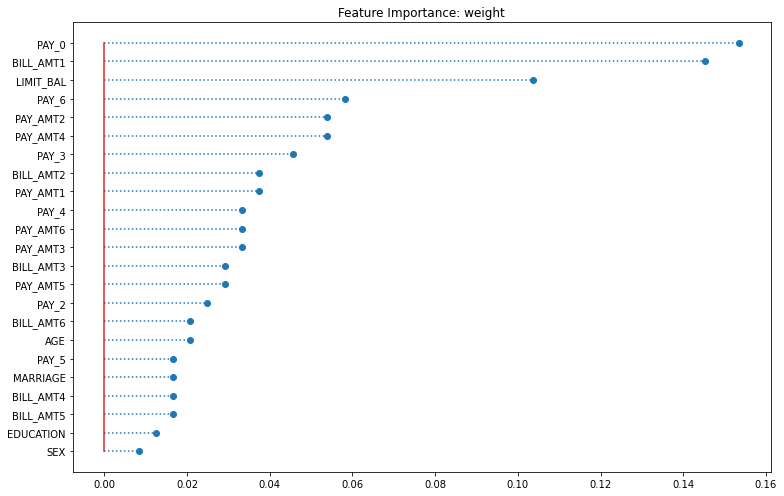

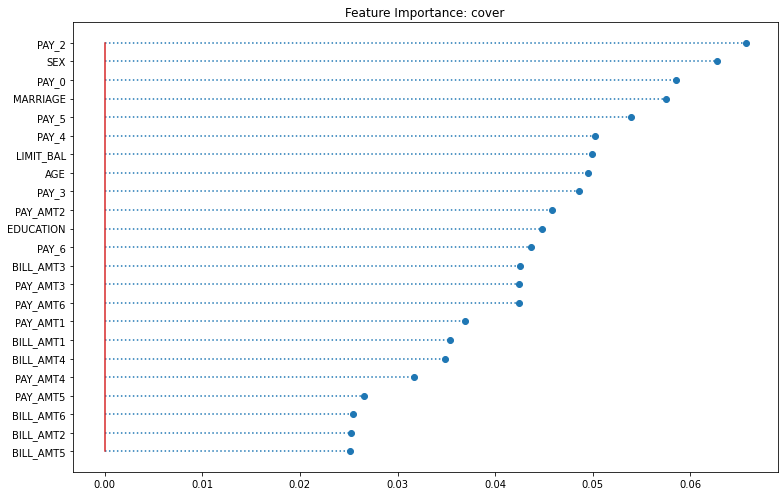

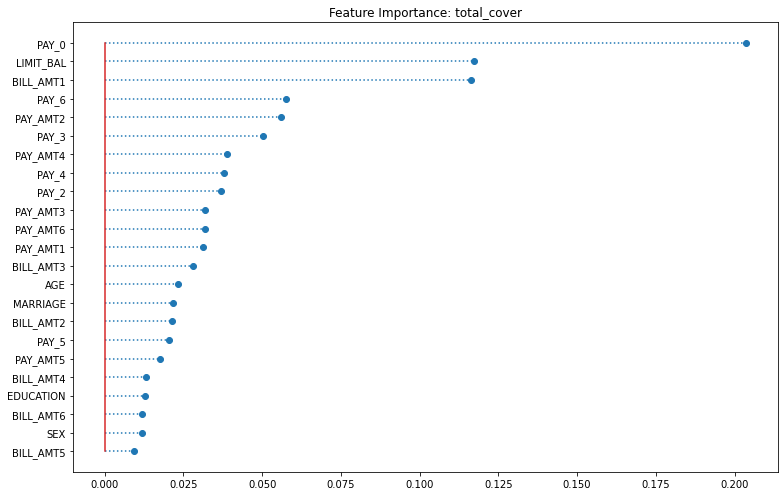

In [46]:
val, ranks =ugbS.importances_calc(xgbBest, X_test, y_test, permutation_repeats=60)

In [47]:
# top 10 zmiennych według permutacji
ranks[(ranks.permutation<=10)].index.to_list()

['PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_6',
 'PAY_5',
 'PAY_AMT3',
 'LIMIT_BAL',
 'PAY_AMT6',
 'PAY_AMT2']

##### Kalibracja pierwotna

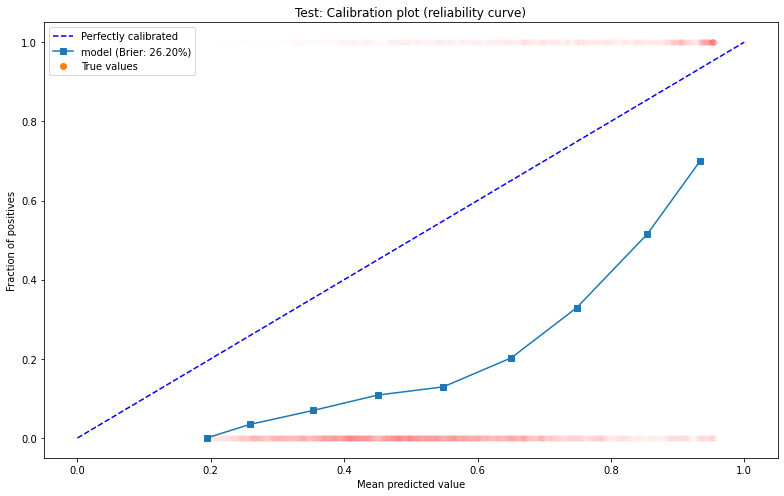

6000


In [48]:
test_proba = xgbBest.predict_proba(X_test)[:, 1]
ugbP.plot_raw_calibration(y_test, test_proba,'Test')

##### Kalibracja docelowa

score min: 0.0, score max: 1329.0
Agregaty do kalibracji


dflt_ind_sum  nondflt_ind_sum  score_mean  PD_init_mean       odr  \
score                                                                      
0               564              301         491      0.911673  0.652023   
1               281              571         583      0.753001  0.329812   
2               167              712         623      0.639049  0.189989   
3               118              745         651      0.548163  0.136732   
4                95              761         673      0.469872  0.110981   
5                65              781         697      0.389609  0.076832   
6                40              799         733      0.282468  0.047676   

            odds  log_odds  PD_final  
score                                 
0       0.533688 -0.627944  0.649825  
1       2.032028  0.709035  0.317225  
2       4.263473  1.450084  0.202837  
3       6.313559  1.842700  0.143058  
4       8.010526  2.080756  0.107046  
5      12.015385  2.486188  0.077092  
6      19.975000  2.994481  0.046335


Parametry kalibracji -->alpha: 0.0151 , beta: -8.0090 , r-sqr: 0.9983


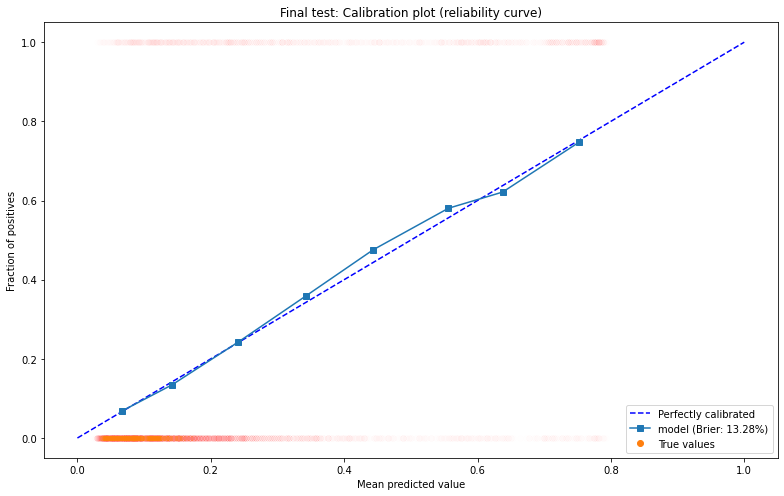

6000

Fin


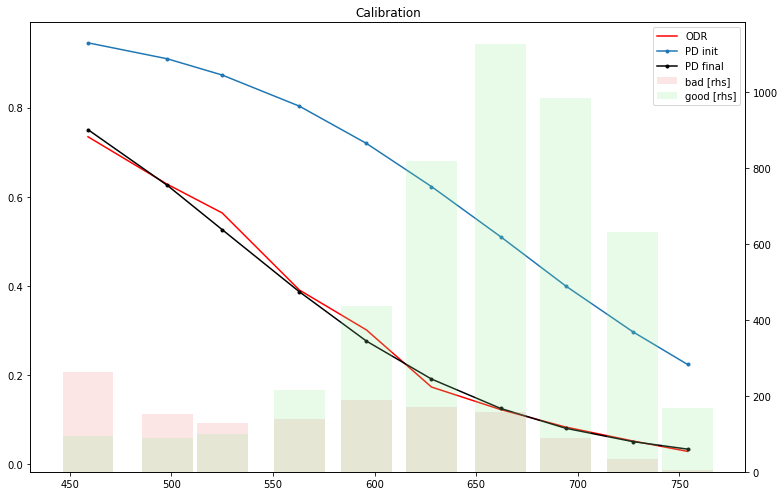

dflt_ind_sum  nondflt_ind_sum  score_mean  PD_init_mean  PD_final_mean  \
score                                                                           
0               263               95         459      0.945300       0.750591   
1               152               90         498      0.909515       0.625766   
2               128               99         525      0.873111       0.526427   
3               138              215         563      0.803281       0.387039   
4               189              438         596      0.719742       0.276393   
5               172              820         628      0.622980       0.191303   
6               158             1128         662      0.510576       0.125445   
7                90              986         694      0.400199       0.080927   
8                35              632         727      0.297555       0.051026   
9                 5              167         754      0.223964       0.034114   

            odr       odds  log_odds  
score                                 
0      0.734637   0.361217 -1.018277  
1      0.628099   0.592105 -0.524071  
2      0.563877   0.773438 -0.256910  
3      0.390935   1.557971  0.443384  
4      0.301435   2.317460  0.840472  
5      0.173387   4.767442  1.561810  
6      0.122862   7.139241  1.965606  
7      0.083643  10.955556  2.393847  
8      0.052474  18.057143  2.893541  
9      0.029070  33.400000  3.508556

In [49]:
df=y_test.to_frame()
df.columns=['dflt_ind']
df['nondflt_ind']=1-df['dflt_ind']
df['PD_init'] = xgbBest.predict_proba(X_test)[:, 1]

####### 
pd_ref=df.loc[df.PD_init<=0.8,'PD_init'].mean()*0.75
PDO=50
score_offset=700
#######
ile_kubelkow=7

df_agg, alpha, beta, r_sqr=ugbS.PD_calibration_from_score(df,ile_kubelkow, pd_ref, score_offset,  PDO)

params_calibration ={ #wlasne
    'score_PD_ref': pd_ref,
    'score_PDO': PDO,
    'score_offset':score_offset,
    'PD_alpha': alpha,
    'PD_beta': beta
}

print(f"Agregaty do kalibracji")
display(df_agg)
print(f"\nParametry kalibracji -->alpha: {alpha:0.4f} , beta: {beta:0.4f} , r-sqr: {r_sqr:0.4f}")
ugbP.plot_raw_calibration(y_test, df['PD_final'],'Final test')
ugbP.plot_final_calibration(df,10,25)

##### Mapowanie ratingów

"Wynik optymalnego bucketow'ania:OPTIMAL"

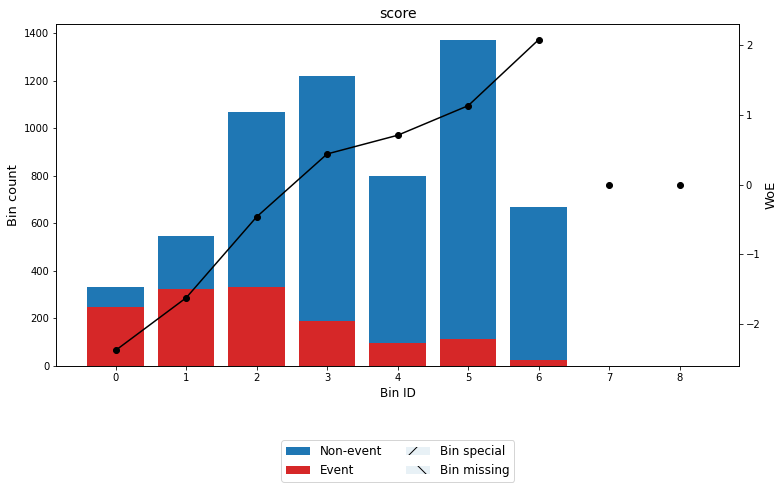

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 473.50)    330   0.055000         81    249    0.754545   
1       [473.50, 550.50)    548   0.091333        224    324    0.591241   
2       [550.50, 615.50)   1066   0.177667        734    332    0.311445   
3       [615.50, 654.50)   1220   0.203333       1031    189    0.154918   
4       [654.50, 674.50)    797   0.132833        699     98    0.122961   
5       [674.50, 718.50)   1369   0.228167       1254    115    0.084003   
6          [718.50, inf)    670   0.111667        647     23    0.034328   
7                Special      0   0.000000          0      0    0.000000   
8                Missing      0   0.000000          0      0    0.000000   
Totals                     6000   1.000000       4670   1330    0.221667   

             WoE        IV        JS  
0      -2.378984  0.404126  0.041202  
1      -1.625078  0.317936  0.035875  
2      -0.462606  0.042768  0.005299  
3       0.440557  0.034657  0.004297  
4       0.708703  0.053858  0.006595  
5       1.133181  0.206303  0.024491  
6       2.080872  0.252307  0.026851  
7            0.0  0.000000  0.000000  
8            0.0  0.000000  0.000000  
Totals            1.311954  0.144611

'Optymalne podziały: '

array([473.5, 550.5, 615.5, 654.5, 674.5, 718.5])

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.57587497
    IV (Jeffrey)             1.31195382
    JS (Jensen-Shannon)      0.14461128
    Hellinger                0.15337742
    Triangular               0.52396858
    KS                       0.45796719
    HHI                      0.16645083
    HHI (normalized)         0.06225719
    Cramer's V               0.48130653
    Quality score            0.02004022

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value  P[A > B]     P[B > A]
        0      1    24.228765 8.554506e-07  1.000000 1.261280e-07
        1      2   117.450708 2.287141e-27  1.000000 1.110223e-16
        2      3    79.211319 5.580942e-19  1.000000 1.110223e-16
        3      4     4.033909 4.459450e-02  0.979435 2.056520e-02
        4      5     8.622550 3.320266e-03  0.99

score                   PD_final                    
            min  max        mean       min       max      mean
PD_rating                                                     
R0          443  473  457.121212  0.708728  0.792620  0.754665
R1          474  550  512.421533  0.432950  0.705611  0.571809
R2          551  615  589.831144  0.223006  0.429259  0.298518
R3          616  654  636.277049  0.137610  0.220409  0.173772
R4          655  674  664.840652  0.105616  0.135834  0.119664
R5          675  718  694.958364  0.057398  0.104202  0.080292
R6          719  779  737.058209  0.023734  0.056589  0.044386

In [50]:
ile_ratingow=7
score_buckets=ugbS.score_to_rating_bucketing(df, ile_ratingow)
params_calibration['rating_buckets']=score_buckets

##### Rating assigment

In [51]:
ugbS.score_to_rating_assign(df, score_buckets,True)

score                   PD_final                    
            min  max        mean       min       max      mean
PD_rating                                                     
R0          443  473  457.121212  0.708728  0.792620  0.754665
R1          474  550  512.421533  0.432950  0.705611  0.571809
R2          551  615  589.831144  0.223006  0.429259  0.298518
R3          616  654  636.277049  0.137610  0.220409  0.173772
R4          655  674  664.840652  0.105616  0.135834  0.119664
R5          675  718  694.958364  0.057398  0.104202  0.080292
R6          719  779  737.058209  0.023734  0.056589  0.044386

##### Strategy curve

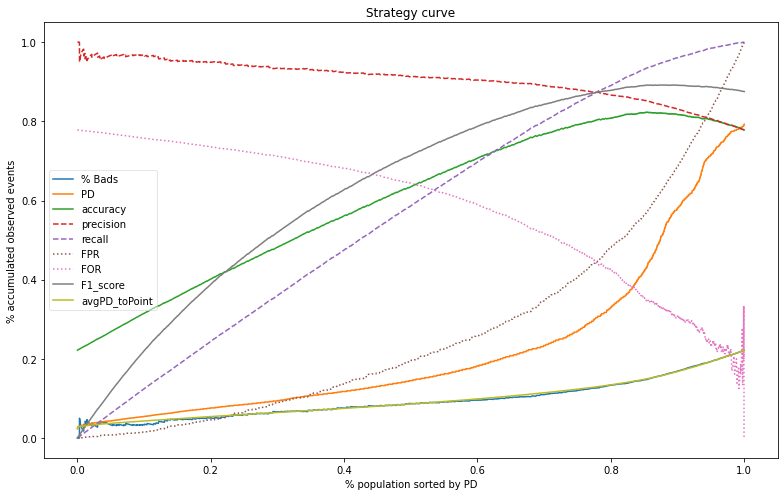

In [52]:
ugbP.plot_strategy_curve(df)

In [53]:
ugbP.plot_strategy_curve_plotly(df)
# Precision -  jak trafię to z jaką skutecznością dobrze
# Recall - ile trafiam z celu (targetu)
# Accuracy - ile mam trafień z całości (target i dopełnienie)
# FPR - jaka część całości non-target stanowią złe predykcje target
# FOR - jaką część przewidzianych non-target stanowią target'y

In [54]:
params_calibration

{'score_PD_ref': 0.3799494355916977,
 'score_PDO': 50,
 'score_offset': 700,
 'PD_alpha': 0.015052468271768865,
 'PD_beta': -8.009033741900499,
 'rating_buckets': [-inf, 473.5, 550.5, 615.5, 654.5, 674.5, 718.5, inf]}

In [55]:
### USTALENIE CUT-OFF
params_calibration['Model_PD_cutoff']=0.1

'proba cut-off (confusion matrix):10.00%'

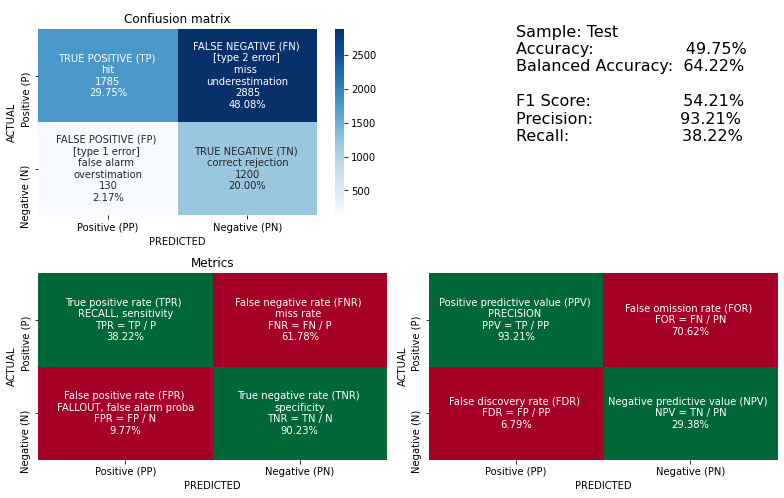

In [56]:
ugbS.make_confusion_matrix(y_test,df.PD_final,params_calibration['Model_PD_cutoff'], title='Test')

##### Użyj modelu

In [57]:
params_calibration

{'score_PD_ref': 0.3799494355916977,
 'score_PDO': 50,
 'score_offset': 700,
 'PD_alpha': 0.015052468271768865,
 'PD_beta': -8.009033741900499,
 'rating_buckets': [-inf, 473.5, 550.5, 615.5, 654.5, 674.5, 718.5, inf],
 'Model_PD_cutoff': 0.1}

In [58]:
#predykcja
df_pred = pd.DataFrame(index=X_val.index)
df_pred['PD_init']=xgbBest.predict_proba(X_val)[:,1]
df_pred_class=np.where(df_pred>params_calibration['Model_PD_cutoff'],1,0)
#score
ugbS.pd_to_score(df_pred,  
            params_calibration['score_PD_ref'], 
            params_calibration['score_offset'], 
            params_calibration['score_PDO'] )
#pd
ugbS.score_to_PD_calibration(df_pred,
                        params_calibration['PD_alpha'], 
                        params_calibration['PD_beta'])
#rating
ugbS.score_to_rating_assign(df_pred,
                      params_calibration['rating_buckets']
                      )
display(df_pred.head())

score min: 0.0, score max: 1329.0


PD_init  score  PD_final PD_rating
5678    0.3707    703  0.070906        R5
9740    0.5312    656  0.134077        R4
29575   0.9091    499  0.621954        R1
18798   0.4314    685  0.090965        R5
19772   0.7355    591  0.291734        R2

'proba cut-off (confusion matrix):10.00%'

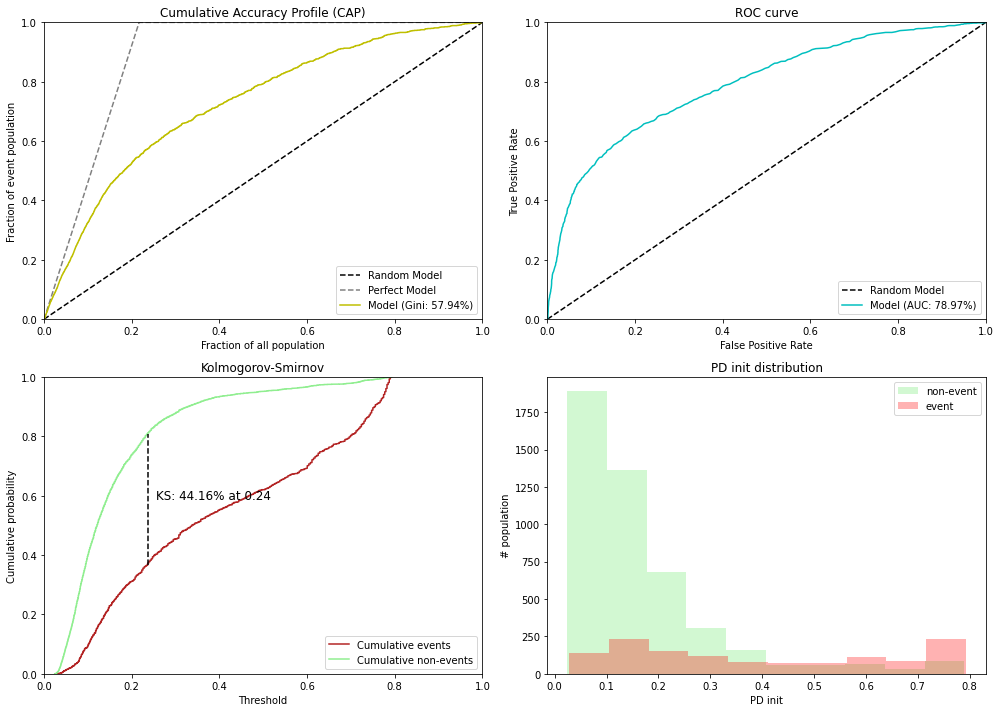

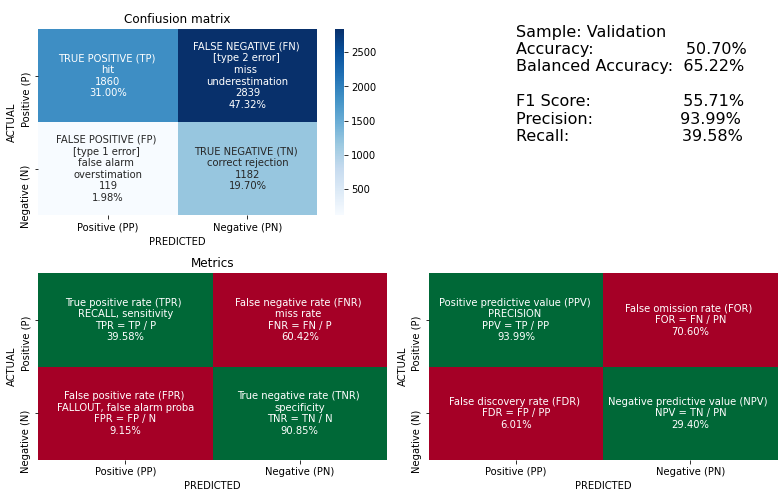

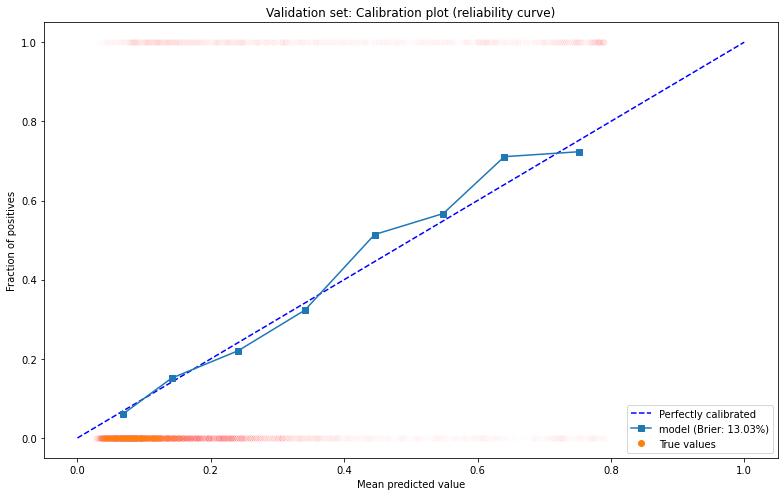

6000


In [59]:

gini, auc, ks, ks_at=ugbP.plot_classification_stats(y_val,df_pred.PD_final)
ugbS.make_confusion_matrix(y_val,df_pred.PD_final,proba_cutoff=params_calibration['Model_PD_cutoff'], title='Validation')
ugbP.plot_raw_calibration(y_val, df_pred.PD_final,'Validation set')